In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import nltk
from nltk.corpus import wordnet as wn
from nltk import edit_distance as ed
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from scipy.sparse import csc_matrix, lil_matrix, csr_matrix
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import FastText
import torch
#import torchtext
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import os
import random

In [2]:
articles = pd.read_csv("shared_articles.csv", delimiter= ',')
interactions = pd.read_csv("users_interactions.csv", delimiter= ',')
comments = pd.read_csv("comments.csv", delimiter= ',', usecols=[0, 1, 4])

#print(articles.head(5))
#print(interactions.head(5))
#print(comments.head(5))

In [3]:
#1
#Pre-processing, labeling event ratings

def pre_process(data, exists=True):
	if exists:
		data = pd.read_csv('df.csv', delimiter= ',')
		return(data)
	else: 
		data['eventRating'] = 0.0
		df = data.groupby(by=['personId','contentId']).sum()
		
		for _, row in df.iterrows():
			if "LIKE" in row['eventType']:
				data.loc[(data['personId'] == row.name[0]) & (data['contentId'] == row.name[1]), 'eventRating'] = 5.0
			elif "FOLLOW" in row['eventType'] and "BOOKMARK" in row['eventType']:
				data.loc[(data['personId'] == row.name[0]) & (data['contentId'] == row.name[1]), 'eventRating'] = 4.0
			elif "FOLLOW" in row['eventType'] or "BOOKMARK" in row['eventType']:
				data.loc[(data['personId'] == row.name[0]) & (data['contentId'] == row.name[1]), 'eventRating'] = 3.0
			elif "COMMENT CREATED" in row['eventType']:
				data.loc[(data['personId'] == row.name[0]) & (data['contentId'] == row.name[1]), 'eventRating'] = 2.0
			elif "VIEW" in row['eventType']:
				data.loc[(data['personId'] == row.name[0]) & (data['contentId'] == row.name[1]), 'eventRating'] = 1.0
		
		data.to_csv('df.csv')
		return(data)

#set to False if eventRatings has not been created yet
interactions = pre_process(interactions, os.path.isfile("df.csv"))
np.mean(interactions["eventRating"])

2.229339528708928

In [4]:
#1

#function that filters dataset according to wanted number of user and article interactions and computes popularity ranking of given set 
def filter_df(data, articles, user_interactions_at_least, article_interactions_at_least, pivot=True):

    #Selecting articles and users with enough interactions
    users_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('personId').size()
    print('number of users:', len(users_interactions_count))
    users_with_enough_interactions_df = users_interactions_count[users_interactions_count >= user_interactions_at_least].reset_index()[['personId']]

    article_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('contentId').size()
    articles_with_enough_interactions_df = article_interactions_count[article_interactions_count >= article_interactions_at_least].reset_index()[['contentId']]

    print("articles with at least", article_interactions_at_least, "interactions:", len(articles_with_enough_interactions_df))
    print("users with at least", user_interactions_at_least, "interactions:", len(users_with_enough_interactions_df))
    print('number of interactions:', len(data))
    interactions_from_selected_users_df = data.merge(users_with_enough_interactions_df, 
                how = 'right',
                left_on = 'personId',
                right_on = 'personId')
    print('number of interactions from users with at least 3 interactions:', len(interactions_from_selected_users_df))


    interactions_from_selected_users_df = interactions_from_selected_users_df.merge(articles_with_enough_interactions_df, 
                how = 'right',
                left_on = 'contentId',
                right_on = 'contentId')
    print("number of interactions users with at least 3 interactions and with articles of at least 2 interactions", len(interactions_from_selected_users_df))

    #article_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('contentId').size()
    #articles_with_enough_interactions_df = article_interactions_count[article_interactions_count >= article_interactions_at_least].reset_index()[['contentId']]
    articles_fil = articles[articles['contentId'].isin(articles_with_enough_interactions_df['contentId'])]
    print("num articles:", len(articles_fil))

    #select unique item/user interactions
    if  pivot==False:
        #interactions_filtered = interactions_from_selected_users_df.groupby(['personId', 'contentId'])['eventRating'].sum().reset_index() 
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']].drop_duplicates()
        #item_popularity = interactions_selected.groupby('contentId')['eventRating'].sum().sort_values(ascending=False).reset_index()
    else:
        interactions_df =interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_filtered.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)
    
    item_popularity = []

    print('number of of unique user/item interactions:', len(interactions_filtered))

    return(interactions_filtered, interactions_df, articles_fil)

interactions_selected, interactions_df, articles = filter_df(data=interactions, articles=articles, user_interactions_at_least=3, article_interactions_at_least=2, pivot=True)  
interactions_selected.head(20)  

number of users: 1895
articles with at least 2 interactions: 2744
users with at least 3 interactions: 1400
number of interactions: 72312
number of interactions from users with at least 3 interactions: 71244
number of interactions users with at least 3 interactions and with articles of at least 2 interactions 70849
num articles: 2760
number of of unique user/item interactions: 1400


contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9212075797126931087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9207251133131336884,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9199575329909162940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9196668942822132778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9188188261933657343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9172914609055320039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9156344805277471150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9120685872592674274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
user_ids = list(interactions_selected.index)
content_ids = list(interactions_selected.T.index)
#mask = np.random.rand(len(interactions_selected)) < 0.8
#train_set = interactions_selected[mask] 
#test_set = interactions_selected[~mask] 

#test_set.head(10)
print(user_ids==interactions_selected.index.unique().values)
len(interactions_selected.index.unique().values)

print(885269153482673496 in content_ids)
#print(len(user_ids), ((interactions_df[interactions_df["personId"]].drop_duplicates)))


[ True  True  True ...  True  True  True]
False


In [6]:
#indexing by personId
pre_processed_data_index = interactions_df.set_index('personId')
#pre_processed_data_index = interactions_selected

#train-test split
train_set, test_set = train_test_split(interactions_df,  stratify=interactions_df['personId'], train_size=0.80)
train_set_index = train_set.set_index('personId')
test_set_index = test_set.set_index('personId')

#train_set_index = train_set
#test_set_index = test_set


print('Train set size:', len(train_set))
print('Test set size:', len(test_set))
af=[0 for i in range(0, len(list(test_set_index.index.unique().values))) if not (list(test_set_index.index.unique().values))[i] in user_ids]
print(af)
print((885269153482673496 in train_set.index.unique().values))
885269153482673496 in interactions_df['personId']

Train set size: 56679
Test set size: 14170
[]
False


False

In [7]:
#from sklearn.neighbors import NearestNeighbors
#knn = NearestNeighbors(metric='cosine', algorithm='brute')
#knn.fit(train_set)
#distances, indices = knn.kneighbors(test_set, n_neighbors=101)

#indices[0][0]
#test_set.iloc[[0,2,3]]

#idx = test_set.index.get_loc(-8802075878443651241)
#nearest_rows = indices[idx]
#print(idx)
#print(np.max(nearest_rows))
#print(interactions_selected[-9216926795620865886])

#interactions_selected.corrwith(interactions_selected[-9216926795620865886]).sort_values(ascending=False).head(10)
#user_id = -8802075878443651241
#user_list = interactions[interactions['personId'] == user_id]
#highest_rated_item = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId'].iloc[0]
#print(movie_id)


#print(list(range(len(interactions_selected["personId"]))))
#item_matrix_sparse = csr_matrix(interactions_selected.T)
#user_matrix_sparse = csr_matrix(interactions_selected)

#users = dict(zip(user_ids, list(range(len(interactions_df["personId"])))))
#contents = dict(zip(content_ids, list(range(len(interactions_df["contentId"])))))
#users_inv = dict(zip(list(range(len(interactions_df["personId"]))), user_ids))
#contents_inv = dict(zip(list(range(len(interactions_df["contentId"]))), content_ids))

#def find_similar(id, matrix, dictionary, dictionary_inv, k):
#     
#    neighbour_ids = []
#     
 #   idx = dictionary[id]
  #  vec = matrix[idx]
#    k+=1
#    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
#    kNN.fit(matrix)
#    vec = vec.reshape(1,-1)
#    neighbour = kNN.kneighbors(vec, return_distance=False)
#    for i in range(0,k):
#        n = neighbour.item(i)
#        neighbour_ids.append(dictionary_inv[n])
#    neighbour_ids.pop(0)
#    return neighbour_ids

#similar_ids = find_similar(content_id, item_matrix_sparse, contents, contents_inv, 10)
#print(similar_ids)

#tm= train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)
#tm.head(10)

#kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
#kNN.fit(matrix)

def find_similar(self, id, matrix, dictionary, dictionary_inv, k):
     
        neighbour_ids = []
        idx = dictionary.get(id)
        #print("item name:", id, "item dict index:", idx)
        vec = matrix[idx]
        k+=1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
        kNN.fit(matrix)
        vec = vec.reshape(1,-1)
        neighbour = kNN.kneighbors(vec, return_distance=False)
        for i in range(0,k):
            n = neighbour.item(i)
            neighbour_ids.append(dictionary_inv.get(n))
        neighbour_ids.pop(0)
        return neighbour_ids


In [8]:

class CFrecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, items=None, item_based=True):
        self.item_matrix_sparse = csr_matrix(interactions_selected.T)
        self.user_matrix_sparse = csr_matrix(interactions_selected)

        self.users = dict(zip(user_ids, list(range(len(user_ids)))))
        self.contents = dict(zip(content_ids, list(range(len(content_ids)))))
        self.users_inv = dict(zip(list(range(len(user_ids))), user_ids))
        self.contents_inv = dict(zip(list(range(len(content_ids))), content_ids))

        self.item_based = item_based
        self.items = items

        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def find_similar(self, id, matrix, dictionary, dictionary_inv, k):
     
        neighbour_ids = []
        idx = dictionary.get(id)
        #print("item name:", id, "item dict index:", idx)
        vec = matrix[idx]
        k+=1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
        kNN.fit(matrix)
        vec = vec.reshape(1,-1)
        neighbour = kNN.kneighbors(vec, return_distance=False)
        for i in range(0,k):
            n = neighbour.item(i)
            neighbour_ids.append(dictionary_inv.get(n))
        neighbour_ids.pop(0)
        return neighbour_ids
    
    def users_highest_item(self, user_id):
        user_list = interactions_df[interactions_df['personId'] == user_id]
        highest_rated_item = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId'].iloc[0]
        #print(highest_rated_item) 
        return(highest_rated_item)
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=101, verbose=False):

        if self.item_based:
            #find users highest rated item, then find similar items to it using cosine similarity
            similar_item_to = self.users_highest_item(user_id)
            recommended_items = self.find_similar(id=similar_item_to, matrix=self.item_matrix_sparse, dictionary=self.contents, dictionary_inv=self.contents_inv, k=topn)
            recommendations = interactions_df[interactions_df['contentId'].isin(recommended_items)]

        else:
            #find similar users using cosine similarity, then find highest rated item for each highest rating user
            similar_user_to = self.find_similar(id=user_id, matrix=self.user_matrix_sparse, dictionary=self.users, dictionary_inv=self.users_inv, k=topn)
            recommended_items = [self.users_highest_item(user) for user in similar_user_to]
            recommendations = interactions_df[interactions_df['contentId'].isin(recommended_items)]

        #sort recommended items based on event rating
        #print(len(recommendations))
        #sorted_user_predictions = recommendations.sort_values(ascending=False).reset_index()

        # Recommend the highest predicted rating items that user has not interacted with
        #print(recommendations)
        recommendations_df = recommendations[~recommendations['contentId'].isin(items_to_ignore)].sort_values(by='eventRating', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventRating', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

#users = dict(zip(user_ids, list(range(len(interactions_df["personId"])))))    
#print(users.get(list(test_set.T.index)[0]))    
user_recommender_model = CFrecommender(items=articles, item_based=False)
item_recommender_model = CFrecommender(items=articles, item_based=True)
item_recommender_model.recommend_items(-9016528795238256703)

,personId,contentId,eventRating
50241,9210530975708218054,3660989387512978561,5.0
50226,9210530975708218054,3660989387512978561,5.0
22078,1493119272824026132,-3678789633202302491,5.0
22077,1493119272824026132,-3678789633202302491,5.0
22076,1493119272824026132,-3678789633202302491,5.0
...,...,...,...
10540,-3992639648918314515,-6590819806697898649,5.0
10541,-3992639648918314515,-6590819806697898649,5.0
53082,-3203894957285229214,4428409432282393251,5.0
37156,-9016528795238256703,569574447134368517,5.0


In [9]:
class Recall_n:

    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=12):
        interacted_items = self.get_items_interacted(person_id, pre_processed_data_index)
        all_items = set(articles['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        #print(person_id)
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=1000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=101, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
            #print(len(list(test_set_index.index.unique().values)), len(user_ids))
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
recall_n_evaluator = Recall_n() 

In [29]:
class NDCG:

    def dcg_at_k(self, r, k, method=0):
        """Score is discounted cumulative gain (dcg)
        Relevance is positive real values.  Can use binary
        as the previous methods.
        Example from
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
        >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
        >>> dcg_at_k(r, 1)
        3.0
        >>> dcg_at_k(r, 1, method=1)
        3.0
        >>> dcg_at_k(r, 2)
        5.0
        >>> dcg_at_k(r, 2, method=1)
        4.2618595071429155
        >>> dcg_at_k(r, 10)
        9.6051177391888114
        >>> dcg_at_k(r, 11)
        9.6051177391888114
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
            k: Number of results to consider
            method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                    If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
        Returns:
            Discounted cumulative gain
        """
        r = np.asfarray(r)[:k]
        if r.size:
            if method == 0:
                return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
            elif method == 1:
                return np.sum(r / np.log2(np.arange(2, r.size + 2)))
            else:
                raise ValueError('method must be 0 or 1.')
        return 0.


    def ndcg_at_k(self, r, k, method=0):
        """Score is normalized discounted cumulative gain (ndcg)
        Relevance is positive real values.  Can use binary
        as the previous methods.
        Example from
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
        >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
        >>> ndcg_at_k(r, 1)
        1.0
        >>> r = [2, 1, 2, 0]
        >>> ndcg_at_k(r, 4)
        0.9203032077642922
        >>> ndcg_at_k(r, 4, method=1)
        0.96519546960144276
        >>> ndcg_at_k([0], 1)
        0.0
        >>> ndcg_at_k([1], 2)
        1.0
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
            k: Number of results to consider
            method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                    If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
        Returns:
            Normalized discounted cumulative gain
        """
        dcg_max = self.dcg_at_k(sorted(r, reverse=True), k, method)
        if not dcg_max:
            return 0.
        return self.dcg_at_k(r, k, method) / dcg_max
    
    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def evaluate_model_for_user(self, model, person_id, k):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user

        personal_recommendations = model.recommend_items(person_id, items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=101)
        ndcg = self.ndcg_at_k(personal_recommendations['eventRating'], k)

        random.seed(12)
        personal_recommendations_rand = random.sample(list(interactions_df['eventRating']), 1000)
        ndcg_rand = self.ndcg_at_k(personal_recommendations_rand, k)

        person_metrics = {'ndcg':ndcg,
                          'ndcg_rand': ndcg_rand,
                          'comp_rand': (ndcg-ndcg_rand),
                          'interacted_count': interacted_items_count_testset}
        return person_metrics

    def evaluate_model(self, model, k):
            #print('Running evaluation for users')
            people_metrics = []
            for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
                person_metrics = self.evaluate_model_for_user(model, person_id, k)  
                person_metrics['_person_id'] = person_id
                people_metrics.append(person_metrics)
            print('%d users processed' % idx)

            detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
            ndcg = detailed_results_df['ndcg'].sum() / len(detailed_results_df)
            ndcg_comp = detailed_results_df['comp_rand'].sum() / len(detailed_results_df)
            global_metrics = {'modelName': model.get_model_name(),
                            'ndcg': ndcg,
                            'ndcg_comp': ndcg_comp}    
            return global_metrics, detailed_results_df    

recall_ndcg_evaluator = NDCG() 

In [25]:
#Evaluating Item-based model

print('Item-based recommendation model: Recall_N:')
pop_global_metrics, pop_detailed_results_df = recall_n_evaluator.evaluate_model(item_recommender_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

print('Item-based recommendation model: NDCG:')
pop_global_metrics, pop_detailed_results_df = recall_ndcg_evaluator.evaluate_model(item_recommender_model, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Item-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.01870396424728958, 'recall@10': 0.023090292145990236}
Item-based recommendation model: NDCG:
                  personId            contentId  eventRating
56764 -9016528795238256703  5424502143558028097          5.0
63290 -2525380383541287600  7270966256391553686          5.0
63294 -1578287561410088674  7270966256391553686          5.0
63293 -2511855597392146401  7270966256391553686          5.0
11896  -108842214936804958 -6195775145989617417          5.0
...                    ...                  ...          ...
54926 -9016528795238256703  5008913705695203000          5.0
54925 -9016528795238256703  5008913705695203000          5.0
54924 -9016528795238256703  5008913705695203000          5.0
54923 -9016528795238256703  5008913705695203000          5.0
54922 -9016528795238256703  5008913705695203000          5.0

[101 rows x 3 columns]
               

,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
8,1.0,0.4826,0.5174,274,-1032019229384696495
1,1.0,0.4826,0.5174,256,3609194402293569455
5,1.0,0.4826,0.5174,222,-1443636648652872475
94,1.0,0.4826,0.5174,196,-2626634673110551643
38,1.0,0.4826,0.5174,135,-3596626804281480007
194,1.0,0.4826,0.5174,123,-2979881261169775358
36,1.0,0.4826,0.5174,119,2416280733544962613
159,1.0,0.4826,0.5174,119,3636910968448833585
125,1.0,0.4826,0.5174,114,3302556033962996625
4,1.0,0.4826,0.5174,99,-709287718034731589


In [12]:
print('User-based recommendation model: Recall_N:')
pop_global_metrics, pop_detailed_results_df = recall_n_evaluator.evaluate_model(user_recommender_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

print('User-based recommendation model: NDCG:')
pop_global_metrics, pop_detailed_results_df = recall_ndcg_evaluator.evaluate_model(user_recommender_model, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

User-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.0133245055036001, 'recall@10': 0.01564181080857403}
User-based recommendation model: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'ndcg': 1.0, 'ndcg_comp': 0.5174000115547485}


,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
8,1.0,0.4826,0.5174,274,-1032019229384696495
1,1.0,0.4826,0.5174,256,3609194402293569455
5,1.0,0.4826,0.5174,222,-1443636648652872475
94,1.0,0.4826,0.5174,196,-2626634673110551643
38,1.0,0.4826,0.5174,135,-3596626804281480007
194,1.0,0.4826,0.5174,123,-2979881261169775358
36,1.0,0.4826,0.5174,119,2416280733544962613
159,1.0,0.4826,0.5174,119,3636910968448833585
125,1.0,0.4826,0.5174,114,3302556033962996625
4,1.0,0.4826,0.5174,99,-709287718034731589


In [13]:
# 4-6
# Function for generating and plotting pearson correlation scores

"""
	Takes two item-user matrices and calculates pearson correlation first on a per-user basis and plots them. 
	Then the correlation scores are averaged to see if there is a more global correlation between the two scoring systems.

	Assumes that the rows represent items (documents) and the columns represent users 
	and that the rows and columns are in the same order between the matrices
"""
def pearson_analyze(M1, M2):
	correlations = []

	for col_index in range(M1.get_shape()[1]):
		user_vec_1 = M1.getcol(col_index).toarray().flatten()
		user_vec_2 = M2.getcol(col_index).toarray().flatten()

		# Documents the user hasn't interacted with should not affect the correlation
		nonzero_elements = [user_vec_1[i] != 0 and user_vec_2[i] != 0 for i, _ in enumerate(user_vec_1)]

		user_vec_1 = user_vec_1[nonzero_elements]
		user_vec_2 = user_vec_2[nonzero_elements]

		if len(user_vec_1) < 2 or len(user_vec_2) < 2:
			correlations += [np.nan]
		else:
			correlations += [pearsonr(user_vec_1, user_vec_2)[0]]
	
	print(correlations)

	fig, ax = plt.subplots()
	plt.xlim(-1.1,1.1)
	ax.scatter(correlations, [0] * len(correlations))
	ax.set(yticklabels=[])
	ax.tick_params(left=False)

	print("Average correlation between users: " + str(np.nanmean(correlations)))


In [14]:
# 4
# Generate item-user matrix of the ratings generated in previous tasks

unique_users = comments["personId"].unique()
unique_items = comments["contentId"].unique()

unique_users.sort()
unique_items.sort()

event_rating_matrix = csc_matrix((len(unique_items), len(unique_users)), dtype=float)

for index, row in interactions.iterrows():
	item_index = np.where(unique_items == row["contentId"])[0]
	user_index = np.where(unique_users == row["personId"])[0]

	if len(item_index) > 0 and len(user_index) > 0:
		event_rating_matrix[item_index[0], user_index[0]] = row['eventRating']

C:\Users\mk473\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


C:\Users\mk473\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[nan, 0.8701834994322271, nan, nan, nan, 0.7282857650564181, nan, nan, nan, 0.7436880695485402, nan, nan, nan, nan, -1.0, nan, nan, nan, nan, nan, 1.0, 0.933715920413735, nan, nan, nan, nan, nan, nan, nan, -0.3053921602750109, nan, nan, nan, nan, nan, nan, 0.5494715472463982, nan, nan, nan, 0.9516507564270372, nan, nan, nan, nan, nan, -0.14454983983924735, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.30482039522022825, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.9475219378626141, nan, nan, nan, nan, 0.7048228408285259, nan, nan, 1.0, 0.6289885892563474, nan, nan, 0.8647826863066554, nan, 0.04972740334068845, nan, nan, nan, nan, nan, nan, nan, nan, 0.6811503764465061, 0.12357472726465157, -0.549556867976393, 0.6640833235684831, nan, 0.5648426009487244, 0.32717341708256353, nan, nan, 0.9990368367465591, nan, nan, nan, 0.33448747562053277, -1.0, 0.1343967311897509, nan, nan, nan, nan, nan, 0.9723947647950538, nan, nan, 0.446799212619983, nan, 0.9960368966744

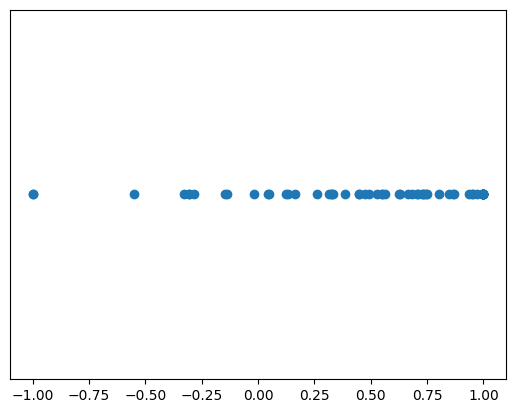

In [15]:
# 4
# Generate item-user matrix from comments using vader sentiment analyzer
vader = SentimentIntensityAnalyzer()

vader_item_user_matrix = csc_matrix((len(unique_items), len(unique_users)), dtype=float)

for index, row in comments.iterrows():
	item_index = np.where(unique_items == row["contentId"])[0][0]
	user_index = np.where(unique_users == row["personId"])[0][0]
	vader_item_user_matrix[item_index, user_index] = vader.polarity_scores(row["comment"])["compound"]

pearson_analyze(vader_item_user_matrix, event_rating_matrix)

[nan, -0.7701943058336475, nan, nan, nan, -0.12312495393875672, nan, nan, nan, -0.029447165605417658, nan, nan, nan, nan, -1.0, nan, nan, nan, nan, nan, -1.0, -0.3779996308599157, nan, nan, nan, nan, nan, nan, nan, 0.12724156228098904, nan, nan, nan, nan, nan, nan, -0.9862882588590003, nan, nan, nan, -0.9494068060614245, nan, nan, nan, nan, nan, 0.15932154194206447, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2540393520155438, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.20283444547569918, nan, nan, nan, nan, -0.27739848860379895, nan, nan, -1.0, -0.5043328788113142, nan, nan, 0.29369235682058215, nan, 0.22874655675079553, nan, nan, nan, nan, nan, nan, nan, nan, 0.13423121104280486, -0.8465889640802727, -0.9542731412018022, -0.0003377542923783672, nan, -0.16707997602864472, -0.09312424557661782, nan, nan, 0.5228913141327353, nan, nan, nan, -0.3092209497852341, -1.0, 0.01907310532678911, nan, nan, nan, nan, nan, 0.12708768311331403, nan, nan, -0.37208315893

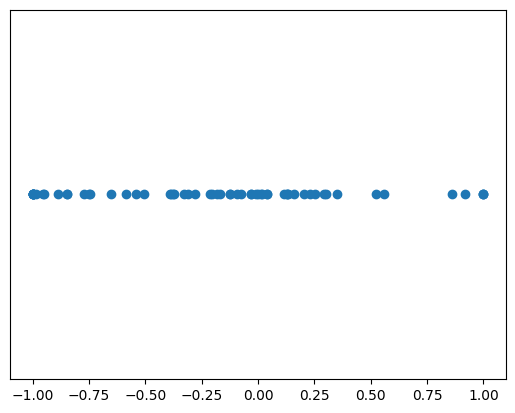

In [16]:
# 5
# Same as #4 but the vader scores are replaced with the comments' size in tokens

token_item_user_matrix = csc_matrix((len(unique_items), len(unique_users)), dtype=float)

for index, row in comments.iterrows():
	item_index = np.where(unique_items == row["contentId"])[0][0]
	user_index = np.where(unique_users == row["personId"])[0][0]
	token_item_user_matrix[item_index, user_index] = len(word_tokenize(row["comment"]))

pearson_analyze(token_item_user_matrix, event_rating_matrix)

[nan, -0.838092151120853, nan, nan, nan, -0.24121008958538528, nan, nan, nan, -0.6182203990363625, nan, nan, nan, nan, -1.0, nan, nan, nan, nan, nan, -1.0, -0.026555207395802326, nan, nan, nan, nan, nan, nan, nan, -0.1007990052981007, nan, nan, nan, nan, nan, nan, -0.8788127063065245, nan, nan, nan, -0.16531163063339518, nan, nan, nan, nan, nan, 0.2910458226635454, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.04180800007523098, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.14961494836016365, nan, nan, nan, nan, -0.6825531852641651, nan, nan, -1.0, 0.4152799057041826, nan, nan, 0.6447771391916297, nan, -0.42621629626756496, nan, nan, nan, nan, nan, nan, nan, nan, -0.5650777225573528, -0.9217917747017879, -0.31164739068869207, -0.19810216404623876, nan, -0.15064702861547383, -0.10482918577075936, nan, nan, -1.0, nan, nan, nan, -0.057112655450696076, 1.0, 0.2519167274263862, nan, nan, nan, nan, nan, -0.6162915083777221, nan, nan, 0.36975046473512363, nan, -0.

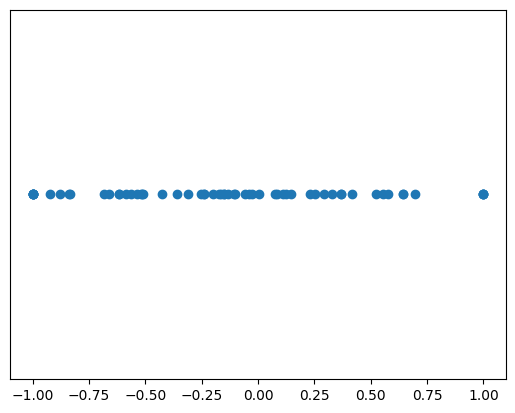

In [17]:
# 6
# Same as #4 but the vader scores are replaced with the comments' ratio of stopwords and words with uncommon characters to other words

stopwords_list = stopwords.words("english") + stopwords.words('portuguese')

stopword_ratio_item_user_matrix = csc_matrix((len(unique_items), len(unique_users)), dtype=float)

for index, row in comments.iterrows():
	item_index = np.where(unique_items == row["contentId"])[0][0]
	user_index = np.where(unique_users == row["personId"])[0][0]

	tokens = word_tokenize(row["comment"])

	stopwords_and_uncommon_chars = [token for token in tokens if token.lower() in stopwords_list or not token.isalpha()]

	stopword_ratio_item_user_matrix[item_index, user_index] = len(stopwords_and_uncommon_chars) / len(tokens)

pearson_analyze(stopword_ratio_item_user_matrix, event_rating_matrix)

In [30]:
# 7
# Content based recommender system where items are represented by vader sentiment analysis scores

item_ids = articles['contentId'].tolist()
item_representation_matrix = [list(vader.polarity_scores(row['title'] + " " + row['text']).values()) for _, row in articles.iterrows()]

print(item_representation_matrix)

[[0.028, 0.822, 0.149, 0.9992], [0.0, 0.845, 0.155, 0.9917], [0.014, 0.94, 0.046, 0.8442], [0.034, 0.813, 0.153, 0.9997], [0.023, 0.835, 0.141, 0.998], [0.03, 0.966, 0.004, -0.946], [0.008, 0.946, 0.046, 0.9967], [0.027, 0.892, 0.081, 0.9996], [0.011, 0.889, 0.1, 0.9771], [0.065, 0.809, 0.126, 0.9993], [0.012, 0.862, 0.126, 0.9984], [0.015, 0.985, 0.0, -0.6808], [0.031, 0.963, 0.006, -0.9924], [0.008, 0.857, 0.135, 0.9986], [0.0, 0.836, 0.164, 0.9764], [0.029, 0.773, 0.198, 0.9987], [0.043, 0.946, 0.011, -0.9371], [0.033, 0.85, 0.118, 0.9979], [0.022, 0.978, 0.0, -0.3595], [0.01, 0.99, 0.0, -0.3736], [0.07, 0.857, 0.074, -0.7647], [0.04, 0.8, 0.16, 0.9989], [0.012, 0.849, 0.139, 0.9866], [0.0, 0.892, 0.108, 0.9825], [0.016, 0.893, 0.091, 0.9936], [0.0, 1.0, 0.0, 0.0], [0.089, 0.846, 0.065, -0.9353], [0.012, 0.858, 0.13, 0.997], [0.173, 0.803, 0.024, -0.9832], [0.055, 0.894, 0.051, 0.3182], [0.014, 0.89, 0.097, 0.985], [0.077, 0.843, 0.08, -0.3532], [0.086, 0.79, 0.124, 0.9994], [0.059,

In [31]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = item_representation_matrix[idx]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = lil_matrix(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventRating']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = train_set[train_set['contentId'].isin(articles['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

user_profiles = build_users_profiles()
len(user_profiles)

1400

In [32]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], item_representation_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'eventRating']).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles)

In [34]:
print('Content-Based Filtering model 1: Recall_N:')
pop_global_metrics, pop_detailed_results_df = recall_n_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

print('Content-Based Filtering model 1: NDCG:')
pop_global_metrics, pop_detailed_results_df = recall_ndcg_evaluator.evaluate_model(content_based_recommender_model, k=5)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Content-Based Filtering model 1: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.022842009434743026, 'recall@10': 0.04427708350575188}
Content-Based Filtering model 1: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Content-Based', 'ndcg': 1.0, 'ndcg_comp': 0.46307337336062665}


,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
8,1.0,0.536927,0.463073,274,-1032019229384696495
1,1.0,0.536927,0.463073,256,3609194402293569455
5,1.0,0.536927,0.463073,222,-1443636648652872475
94,1.0,0.536927,0.463073,196,-2626634673110551643
38,1.0,0.536927,0.463073,135,-3596626804281480007
194,1.0,0.536927,0.463073,123,-2979881261169775358
36,1.0,0.536927,0.463073,119,2416280733544962613
159,1.0,0.536927,0.463073,119,3636910968448833585
125,1.0,0.536927,0.463073,114,3302556033962996625
4,1.0,0.536927,0.463073,99,-709287718034731589


In [35]:
# 8
# Content based recommender system where items are represented by the vector:
# [Positive Sentiment score, Negative Sentiment Score, Length of the message (in tokens), Ratio of stopwords/uncommon characters, Number of Personal Pronouns]

personal_pronouns = ["i", "me", "my", "mine", "you", "your", "yours", "he", "him", "his", "she", "her", "hers", "it", "its", "they", "them", "their", "theirs", "we", "us", "our", "ours"]

item_representation_matrix = []

for index, row in articles.iterrows():
	full_article = row['title'] + " " + row['text']
	scores = vader.polarity_scores(full_article)
	tokens = word_tokenize(full_article)
	stopwords_and_uncommon_chars = [token for token in tokens if token.lower() in stopwords_list or not token.isalpha()]
	num_of_personal_pronouns = len([token for token in tokens if token.lower() in personal_pronouns])
	
	item_representation_matrix += [[scores['pos'], scores['neg'], len(tokens), len(stopwords_and_uncommon_chars) / len(tokens), num_of_personal_pronouns]]

user_profiles = build_users_profiles()
len(user_profiles)

content_based_recommender_model = ContentBasedRecommender(articles)

print('Content-Based Filtering model 2: Recall_N:')
pop_global_metrics, pop_detailed_results_df = recall_n_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

print('Content-Based Filtering model 2: NDCG:')
pop_global_metrics, pop_detailed_results_df = recall_ndcg_evaluator.evaluate_model(content_based_recommender_model, k=5)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Content-Based Filtering model 2: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.019862616899776545, 'recall@10': 0.04022179922204751}
Content-Based Filtering model 2: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Content-Based', 'ndcg': 1.0, 'ndcg_comp': 0.46307337336062665}


,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
8,1.0,0.536927,0.463073,274,-1032019229384696495
1,1.0,0.536927,0.463073,256,3609194402293569455
5,1.0,0.536927,0.463073,222,-1443636648652872475
94,1.0,0.536927,0.463073,196,-2626634673110551643
38,1.0,0.536927,0.463073,135,-3596626804281480007
194,1.0,0.536927,0.463073,123,-2979881261169775358
36,1.0,0.536927,0.463073,119,2416280733544962613
159,1.0,0.536927,0.463073,119,3636910968448833585
125,1.0,0.536927,0.463073,114,3302556033962996625
4,1.0,0.536927,0.463073,99,-709287718034731589
